# Telling a Story With Data
Business often needs to make decisions now about spending money for the future, 
yet the uncertainty of the future makes this difficult. Being able to make
projections about the future can make this task easier. We'll explore examples
from a food truck and exam scores to illustrate the power of prediction.

## Infrastructure
We'll load all the libraries and custom built functions here to avoid clutter.

In [1]:
from scikitplot.metrics import plot_roc
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def plot_regr(X, y, regr):
    regr.fit(X, y)
    plt.plot(X, y, 'o', label = 'Data')
    y_pred = regr.predict(X)
    label = 'y = %.2f + %.2f*x' % (regr.intercept_, regr.coef_)
    plt.plot(X, y_pred, '-b', label = label)
    title = "Truck Profit (y) vs. City Population (x)"
    plt.xlabel("City Population (10,000s)")
    plt.ylabel("Truck Profit ($10,000s)")
    y_pred = regr.predict(X)
    text = "$R^2$ = %.2f" % r2_score(y_pred, y)
    plt.text(13.75, 21, text)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_log(X, y, clf):
    clf.fit(X, y)

    plt.figure(figsize = (8,8))
    passed = np.where(y == 1)[0]
    failed = np.where(y == 0)[0]
    plt.plot(X[passed,0], X[passed,1], '+', label = 'Passed')
    plt.plot(X[failed,0], X[failed,1], 'o', label = 'Failed')
    plt.xlabel("Exam 1 Score")
    plt.ylabel("Exam 2 Score")
    plt.title("Predicting Pass Rates with Logistic Regression")
    coeff = np.insert(clf.coef_, 0, clf.intercept_)
    coeff = coeff / coeff[2]
    coeff[:2] = -1 * coeff[:2]
    pred = lambda x: coeff[0] + coeff[1]*x
    x_min, x_max = X[:,0].min(), X[:,0].max() 
    t = np.arange(x_min, x_max)
    plt.plot(t, pred(t), '-b', label = 'Decision Boundary')
    text = 'y = %.2f + %.2f*x' % (coeff[0], coeff[1])
    plt.text(60, 30, text)
    y_pred = clf.predict(X)
    text2 = "$R^2$ = %.2f" % r2_score(y_pred, y)
    plt.text(60, 25, text2)
    plt.legend()
    plt.show()

def plot_sigmoid():
    s = lambda x: 1 / (1 + np.exp(-x))
    t = np.arange(-10, 10, .5)
    plt.plot(t, s(t), '-b')
    a = np.arange(-10, 0, .5)
    plt.plot(a, [0.5]*len(a), '--r')
    b = np.arange(0, 0.5, .01)
    plt.plot([0]*len(b), b, '--r')
    plt.annotate('A common threshold: 50%', xy=(0, 0.5), xytext=(1, .65),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.title("The Sigmoid Function")
    plt.xlabel("$X$")
    plt.ylabel("$P(X)$")
    plt.show()
    
    
def plot_gd(X, y, theta, Js):
    fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 10))
    ax0.plot(X, y, 'o', label = 'Data')
    label = 'y = %.2f + %.2f*x' % (theta[0], theta[1])
    # mod X to make math work
    X_mod = np.insert(X, 0, 1, axis = 1)
    y_pred = X_mod.dot(theta)
    ax0.plot(X, y_pred, '-b', label = label)
    ax0.set_xlabel("City Population (10,000s)")

    text = "$R^2$ = %.2f" % r2_score(y_pred, y)
    ax0.text(6, 22, text)
    ax0.set_ylabel("Truck Profit ($10,000s)")
    ax0.set_title("Truck Profit (y) vs. City Population (x)")
    ax0.legend()

    t = np.arange(1, len(Js)+1)
    ax1.plot(t, Js, '.') 
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Cost (MSE)")
    ax1.set_title("Gradient Descent Cost Minimization")
    plt.show()

def gradient_descent(X, y, theta, alpha, iterations):
    # insert columns of ones to make math work
    X = np.insert(X, 0, 1, axis = 1)
    n_rows, n_cols = X.shape
    J_hist = np.zeros(iterations)

    for _ in range(iterations):

        J = 0
        temps = np.zeros(n_cols)
        grads = np.zeros(n_cols)

        # our prediction
        h = lambda a: a.dot(theta)

        # cost function is mean-squared-error
        for i in range(n_rows):
            J += ( h(X[i, :]) - y[i] )**2 / (2*n_rows)
        J_hist[_] = J

        # compute gradients and place in temp. variable
        for j in range(n_cols):
            for i in range(n_rows):
                grads[j] += ( h(X[i, :]) - y[i] ) * X[i,j] / n_rows

            temps[j] = theta[j]- alpha*grads[j]

        # simultaneous update
        for j in range(n_cols):
            theta[j] = temps[j]

    return theta, J_hist
        

## Linear Regression with sklearn
It's best to first get a feel for what's going on by seeing the output of this
procedure first so that we don't get bogged down in the details. Sklearn is a
pre-built library we can use so that we don't have to make our own
implementations of these tools. We'll examine the case of a food truck owner who
is interested in expanding to a new city, but wants to gain more confidence on
his chances of probability before making the leap:

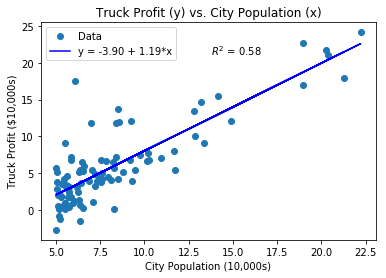

In [2]:
address = 'https://raw.githubusercontent.com/' +\
          'geofflangenderfer/data/master/Assignment2/ex1data1.txt'
data = pd.read_csv(address, header = None).values

X, y = data[:,:-1], data[:,-1]
regr = linear_model.LinearRegression()
plot_regr(X, y, regr)


If the truck owner has the population for the considered town, he can make a
prediction on how profitable his truck will be based on historical data. It
won't be 100% accurate, but it gives him a tool that reduces uncertainty. 



## Linear Regression with custom Gradient Descent
Linear regression works under the hood by minimizing the residuals between the
prediction and true values. This cost function  is minimized with an algorithm
called gradient descent. 

Pretend you're sitting on the top of the hill,blind-folded, and want to get down
from the hill. Which direction should you go? You feel around and one direction
leads higher up and another descends lower. You take the direction header
lower, while continuing to feel for the direction of steepest descent, until
you reach the bottom of the hill. This is what happens in gradient descent,
until we reach the minimum of the cost function.

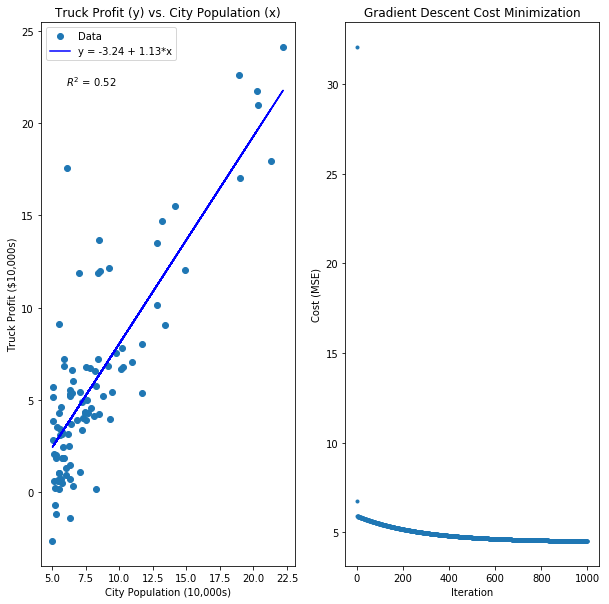

In [3]:
initial_theta = np.zeros(2)
learning_rate = .01
iterations = 1000

theta, J_hist = gradient_descent(X, y, initial_theta, 
                                learning_rate, iterations)

plot_gd(X, y, theta, J_hist)


As you can see, the answers from our custom Gradient Descent algorithm and
sklearn are fairly equal. Though, using the package does allow us to get to our
prediction quicker. 

## Interpreting Linear Regression
Our graphs produced an equation for our prediction and a $R^2$ value. the
coefficients of the equation describe the sensitivity of profit to changes in
population:

- the intercept says that if you go to a town without any residents, you will
  lose $32,400.

- the coefficient of x says that for an increase in city population  by 10,000, 
  the truck will make an additional $11,300.

The $R^2$ value describes how well our prediction models fit the data used to 
train it. $R^2$:

- is in [0,1]
- the closer to one, the more the model explains the variance in the data. 


## Logistic Regression with sklearn
Suppose you have a person's weight and age, and you'd like to
predict his probability of heart attack within one year. You could use a tool
like logistic regression to classify the event as likely or not. 

We'll explore a dataset of exam scores labelled as either passing or failing to
explore this further:

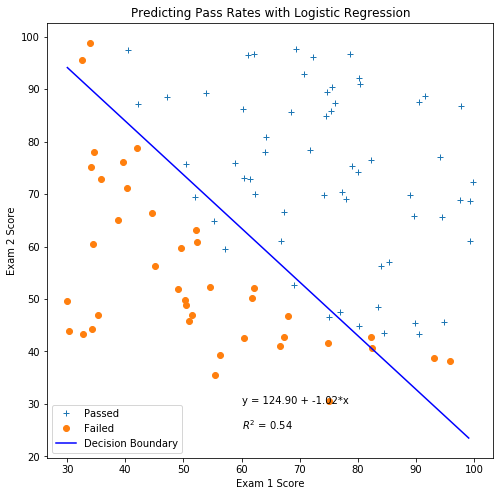

In [4]:
address = 'https://raw.githubusercontent.com/geofflangenderfer/' +\
          'data/master/Assignment2/ex2data1.txt'
data = pd.read_csv(address, header = None).values
X = data[:,:-1]; y = data[:,-1]
clf = linear_model.LogisticRegression(solver='lbfgs')
plot_log(X, y, clf)


## Exercise
Say a student scored 50 on the first exam because she was sick. She thinks she
can do better on the next one with a 90. What are the chances she passes the
class?

In [5]:
data_array = np.array([[50, 90]])
prob_pass = clf.predict(data_array)
print("The probability of passing with %s: %.2f" % (data_array, prob_pass))

The probability of passing with [[50 90]]: 1.00


What are the chances a student passes with a 60 on exam 1 and 64 on exam 2?

In [6]:
#-----------Enter Your Code Here------------#
data_array = np.array([[60, 64]])
prob_pass = clf.predict(data_array)
print("The probability of passing with %s: %.2f" % (data_array, prob_pass))
#-------------------------------------------#

The probability of passing with [[60 64]]: 1.00


## Interpreting Logistic Regression

### The Sigmoid Function
Logistic regression works similarly to linear by finding weights through
gradient descent that minimize its cost function (something different than the
residuals). It takes the dot product of exam scores and solved-coefficients to
come up with a real-value. Next, it turns that value into a probability by 
passing it through the sigmoid function. Finally, each training example of exam
scores is classified as passing or not based on a chosen probability threshold,
usually 50%. 

The sigmoid function is very useful because it maps all real-values to (0, 1).
Let's take a look to see that visually:

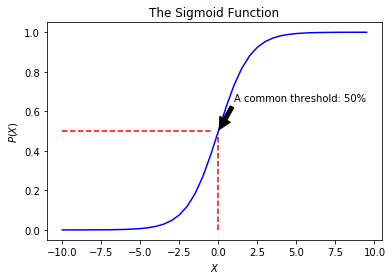

In [7]:
plot_sigmoid()

As you can see, no matter how large X, P(X) goes no higher than one. Likewise,
no matter how small X, P(x) goes no lower than 0. 

### The Coefficients
The process for interpreting the coefficients in logistic regression is similar 
to linear. The difference is we talk in terms of percentages instead of
real-values.

- The intercept can be interpreted as the as the minimum exam 2 score required
  to pass. If you score 0 on exam 1, our model says you need to score ~125%
  on exam 2-a tall task.
- the coefficient of x is interpreted as the change in exam 2 score required 
  to pass for a 1% increase in exam 1 score. If you score 1% higher on exam 1,
  you will need 1.02% less on exam 2 in order to pass.


### ROC curves
These give us a way to compare the rate of correctly passing exam scores
(predicted) to the rate of falsely passing exam scores (predicted). If you
change the classification threshold (usually 50%), these values will vary, which is what
produces the curve. Let's take a look at the ROC for the exam scores:

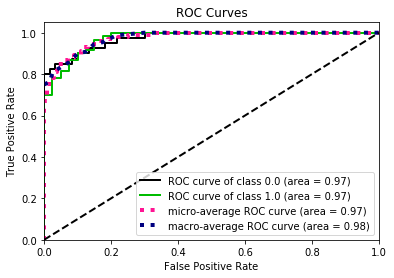

In [8]:
y_pred = clf.fit(X, y).predict_proba(X)
        
# FPR(T) and TPR(T) are functions of the acceptance threshold T
# the roc plots the (fpr, tpr) pairs that result from varying T
plot_roc(y, y_pred)
plt.show()


If you look at the point (0,0.6) for class 1, this is telling you that for the
chosen pass threshold, you can expect a false-positive rate of 0% and a
true-positive rate of 60%. A perfect score would be 100% and this would happen
if the curve was in the far left corner of the graph. This also corresponds to 
an area under the curve of 1.

Google is famous for not wanting any false positives in their hiring 
decisions, so they might choose a similar threshold with a 0 FPR.


## Conclusion
We saw how a food truck owner can get an idea for how profitable a new truck in
a new city can do with linear regression. And, we saw how a student could
predict what score they would need to be fairly confident they would pass.
These tools are effective at giving an idea about the future, but business data
is often more complicated, with more variables. We'll learn more about the
multivariate cases for these tools next time.